In [ ]:
# Uso provisional
from google.colab import drive
# Montamos la unidad de GDrive para conectar Google Drive y Google Colab para lectura/escritura de datos
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importacion de bibliotecas
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [ ]:
# Variables
drive_path = "/content/drive/MyDrive/Trabajo_SCBIO" # Modificar
input_shape = (224, 224, 3) # Nota: input_shape = (224, 224, 3) valor por defecto de MobileNetV2
image_size = (input_shape[0],input_shape[1])
label_map = ['Mano_abierta','Mano_cerrada'] # Modificar, debe corresponder con el nombre de las carpetas del DataSet
classes_number = len(label_map)
batch_size=64 # Debe ser múltiplo de 2 
batch_size_orig=32

In [ ]:
# Data Augmentation:
# Nota, la ejecución es rapida, pero tarda bastante en llenar el directorio 
# Variables:
data_dir = drive_path + '/DataSet_224_Expandido' # Agregar el resto de la ruta donde se aloja el DataSet
n_new_images = 5
# Crea un objeto ImageDataGenerator con algunas transformaciones aleatorias
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=20, # Grados de rotacion aleatoria
    width_shift_range=0.1, # Fraccion del total (1) para mover la imagen
    height_shift_range=0.1, # Fraccion del total (1) para mover la imagen
    brightness_range=[0.25, 2], # Entre 0,5 y 1,5 veces el nivel de brillo original 
    shear_range=0.0,
    zoom_range=0.1, # Rango de zoom
    channel_shift_range=0.8, # Rango de los valores de los canales RGB
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True, # Girar las imagenes horizontalmente
    vertical_flip=True, # Girar las imagenes verticalmente
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)
# Para generar DataSets Aumentados de tamaños n_new_images 2*n_new_images 3*n_new_images 4*n_new_images siendo n_new_images = 5
# Borrar ''' para descomentar, una vez ejecutado se recomienda mantener comentado para evitar aumentar el dataset por error
'''
for _ in range(20):
    for label in label_map:
      # Directorio de origen de las imágenes originales
      source_dir = os.path.join(data_dir, label)

      # Directorio de destino para las imágenes generadas
      dist_dir = os.path.join(data_dir + f"_Aumentadox{n_new_images}", label)

      # Crear el directorio de destino si no existe
      if not os.path.exists(dist_dir):
          os.makedirs(dist_dir)

      # Cargamos cada imagen del directorio de origen y generamos n_new_images imágenes nuevas para cada una
      for filename in os.listdir(source_dir):
          if filename.endswith('.jpg'):
              # Cargamos la imagen original
              img = load_img(os.path.join(source_dir, filename))

              # Convertimos la imagen en un array de numpy
              x = img_to_array(img)

              # Reajustamos el tamaño del array
              x = x.reshape((1,) + x.shape)

              # Generamos 5 imágenes nuevas a partir de la imagen original
              i = 0
              for batch in datagen.flow(x, batch_size=1,
                                        save_to_dir=dist_dir,
                                        save_prefix=os.path.splitext(filename)[0] + '_gen_{}'.format(i),
                                        save_format='jpg'):
                  i += 1
                  if i == n_new_images:
                      break  # Salimos después de generar n_new_images imágenes nuevas
    if n_new_images >= 20:
        break
    n_new_images += 2
'''
# Para generar un DataSet Aumentado de un tamaño n_new_images
'''
n_new_images = 20
for label in label_map:
      # Directorio de origen de las imágenes originales
      source_dir = os.path.join(data_dir, label)

      # Directorio de destino para las imágenes generadas
      dist_dir = os.path.join(data_dir + f"_Aumentadox{n_new_images}", label)

      # Crear el directorio de destino si no existe
      if not os.path.exists(dist_dir):
          os.makedirs(dist_dir)

      # Cargamos cada imagen del directorio de origen y generamos n_new_images imágenes nuevas para cada una
      for filename in os.listdir(source_dir):
          if filename.endswith('.jpg'):
              # Cargamos la imagen original
              img = load_img(os.path.join(source_dir, filename))

              # Convertimos la imagen en un array de numpy
              x = img_to_array(img)

              # Reajustamos el tamaño del array
              x = x.reshape((1,) + x.shape)

              # Generamos 5 imágenes nuevas a partir de la imagen original
              i = 0
              for batch in datagen.flow(x, batch_size=1,
                                        save_to_dir=dist_dir,
                                        save_prefix=os.path.splitext(filename)[0] + '_gen_{}'.format(i),
                                        save_format='jpg'):
                  i += 1
                  if i == n_new_images:
                      break  # Salimos después de generar n_new_images imágenes nuevas
'''

In [ ]:
# Cargamos de train_data/validation_data/test_data del nuevo DataSet
directory = drive_path+'/DataSet_224_Expandido_Aumentadox20' # Modificar en función del Dataset que se quiera emplear
train_data,test_validation_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    class_names = label_map,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Dividimos test_validation_data en test_data y validation_data

num_images = test_validation_data.cardinality().numpy()
num_test_images = num_images // 2
num_validation_images = num_images - num_test_images

test_data = test_validation_data.take(num_test_images)
validation_data = test_validation_data.skip(num_test_images)

Found 15220 files belonging to 2 classes.
Using 10654 files for training.
Using 4566 files for validation.


In [ ]:
# Agregado, filtros aleatorios
def apply_random_filters(image):
    image = tf.image.random_hue(image, 0.08)
    # Nota: al aumentar el set de datos ya se habían aplicado los siguientes filtros
    image = tf.image.random_saturation(image, 0.6, 1.6) 
    image = tf.image.random_brightness(image, 0.05)
    return image

train_data = train_data.map(lambda x, y: (apply_random_filters(x), y))
test_data = test_data.map(lambda x, y: (apply_random_filters(x), y))
validation_data = validation_data.map(lambda x, y: (apply_random_filters(x), y))


In [ ]:
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))
validation_data = validation_data.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
# Configuración de la arquitectura de MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, # definir el tamaño de las imágenes de entrada
    alpha=1.0,
    include_top=False, # exclusión de la capa densa final
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
#base_model.summary() # Descomentar para ver la arquitectura de la red
# Comprobamos que carga el modelo completo a excepción de la capa de Avarage Pooling y Predictions

# OPCIÓN 1: Trabajar con los pesos de las n últimas capas
# Congelar el modelo base de MobileNetV2 para no actualizar los pesos durante el entrenamiento
base_model.trainable = True # utilizar para reseteos
# base_model.trainable = False # utilizar si se desea congelar el modelo completo
# Modificación, deshabilitamos la capacidad de entrenamiento del modelo a excepción de las n últimas capas
n = 10 # Ajustar manualmente según DataSet
for layer in base_model.layers[:-n]: 
    layer.trainable = False
# Creamos un modelo secuencial
model = Sequential()
# Agregamos la red pre-entrenada
model.add(base_model)
# Agregamos una capa de "GlobalAveragePooling2D"
model.add(GlobalAveragePooling2D())
# Agregamos una última capa densa para la clasificación (equivalente a capa de predicciones)
model.add(Dense(len(label_map), activation='softmax'))
# Compilar el modelo para el entrenamiento
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#model.summary() # Descomentar para ver la estructura del modelo
# Dado que siempre estamos obteniendo peores resultados abandonamos este metodo.

Versiones finales para 2 gestos:

In [ ]:
# Configuración de la arquitectura de MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, # definir el tamaño de las imágenes de entrada
    alpha=1.0,
    include_top=False, # exclusión de la capa densa final
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
#base_model.summary() # Descomentar para ver la arquitectura de la red

# Comprobamos que carga el modelo completo a excepción de la capa de Avarage Pooling y Predictions
# OPCIÓN 2: Trabajar el modelo preentrenado sin modificar los pesos de este
# Congelar el modelo base de MobileNetV2 para no actualizar los pesos durante el entrenamiento
base_model.trainable = False # utilizar si se desea congelar el modelo completo
# Creamos un modelo secuencial
mod_model = Sequential()
# Agregamos la red pre-entrenada
mod_model.add(base_model)
# Agregamos una capa de "GlobalAveragePooling2D"
mod_model.add(GlobalAveragePooling2D())
# Se puede cambiar por:
#mod_model.add(layers.Flatten())
# agregamos una capa densa:
mod_model.add(Dense(512, activation='relu'))
mod_model.add(Dropout(0.2))
# Agregamos una última capa densa para la clasificación (equivalente a capa de predicciones)
mod_model.add(Dense(len(label_map), activation='softmax'))
# Compilar el modelo para el entrenamiento
mod_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#mod_model.summary() # Descomentar para ver la estructura del modelo

In [ ]:
# Entrenamiento
n_epochs = 100 # Modificar a conveniencia
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
print('Entrenando mod_model:')
history_modded = mod_model.fit(train_data,epochs=n_epochs,validation_data=validation_data,callbacks=[early_stopping])

Entrenando mod_model:
Epoch 1/100
167/167 [==============================] - 46s 244ms/step - loss: 0.3017 - categorical_accuracy: 0.8779 - val_loss: 0.1711 - val_categorical_accuracy: 0.9293
Epoch 2/100
167/167 [==============================] - 53s 314ms/step - loss: 0.1082 - categorical_accuracy: 0.9600 - val_loss: 0.1867 - val_categorical_accuracy: 0.9266
Epoch 3/100
167/167 [==============================] - 43s 256ms/step - loss: 0.0811 - categorical_accuracy: 0.9696 - val_loss: 0.0715 - val_categorical_accuracy: 0.9699
Epoch 4/100
167/167 [==============================] - 44s 261ms/step - loss: 0.0560 - categorical_accuracy: 0.9792 - val_loss: 0.0957 - val_categorical_accuracy: 0.9668
Epoch 5/100
167/167 [==============================] - 43s 251ms/step - loss: 0.0506 - categorical_accuracy: 0.9826 - val_loss: 0.0628 - val_categorical_accuracy: 0.9752
Epoch 6/100
167/167 [==============================] - 43s 251ms/step - loss: 0.0417 - categorical_accuracy: 0.9844 - val_loss: 

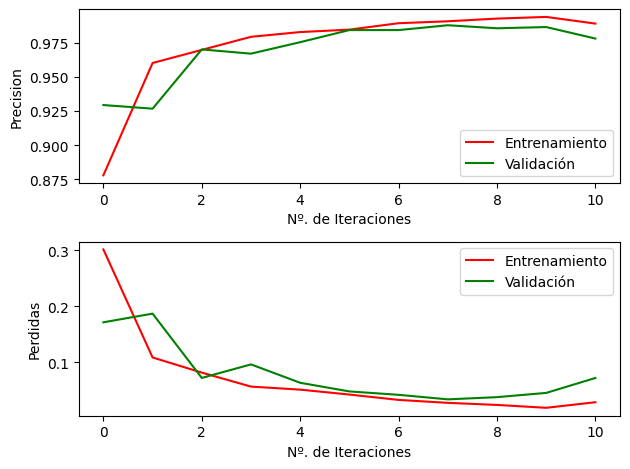

In [ ]:
accu = history_modded.history['categorical_accuracy']
val_acc = history_modded.history['val_categorical_accuracy']
loss = history_modded.history['loss']
val_loss = history_modded.history['val_loss']
epochs = range(len(accu))

# Representación de las perdidas
plt.subplot(211)
plt.plot(epochs,accu,'r',label='Entrenamiento')
plt.plot(epochs,val_acc,'g',label='Validación')
plt.xlabel('Nº. de Iteraciones')
plt.ylabel('Precision')
plt.legend()
# Representación de las perdidas
plt.subplot(212)
plt.plot(epochs,loss,'r',label='Entrenamiento')
plt.plot(epochs,val_loss,'g',label='Validación')
plt.xlabel('Nº. de Iteraciones')
plt.ylabel('Perdidas')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#print('model:')
#test_loss, test_acc = model.evaluate(test_data)
#print('Precisión del conjunto de prueba:', test_acc)
#print('Perdidas del conjunto de prueba:', test_loss)
print('mod_model:')
test_loss, test_acc = mod_model.evaluate(test_data)
print('Precisión del conjunto de prueba:', test_acc)
print('Perdidas del conjunto de prueba:', test_loss)

mod_model:
36/36 [==============================] - 8s 211ms/step - loss: 0.0705 - categorical_accuracy: 0.9757
Precisión del conjunto de prueba: 0.9756944179534912
Perdidas del conjunto de prueba: 0.07046922296285629


In [ ]:
# Guardado del Modelo
save_path = "/content/drive/MyDrive/Repositorio_Modelos/Nuevos"
#model.save(save_path+'/MobileNetV2_Reentrenado_DataSet_224_Simple_V3.h5') # Modificar si no se deseea reescribir el modelo
mod_model.save(save_path+'/MobileNetV2_modificado_DataSet_224_Simple_V5.h5')

#Guardado unicamente de los pesos
#model.save_weights(save_path+'/MobileNetV2_Reentrenado_Pesos_DataSet_224_Simple_V3.h5')
mod_model.save_weights(save_path+'/MobileNetV2_modificado_Pesos_DataSet_224_Simple_V5.h5')

# Notas: Extraccón de pesos
#model.get_weights() 
#mod_model.get_weights() 

Trateos extra 2:

In [ ]:
# Configuración de la arquitectura de MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, # definir el tamaño de las imágenes de entrada
    alpha=1.0,
    include_top=False, # exclusión de la capa densa final
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
#base_model.summary() # Descomentar para ver la arquitectura de la red

# Comprobamos que carga el modelo completo a excepción de la capa de Avarage Pooling y Predictions
# OPCIÓN 2: Trabajar el modelo preentrenado sin modificar los pesos de este
# Congelar el modelo base de MobileNetV2 para no actualizar los pesos durante el entrenamiento
base_model.trainable = False # utilizar si se desea congelar el modelo completo
# Creamos un modelo secuencial
mod_model = Sequential()
# Agregamos la red pre-entrenada
mod_model.add(base_model)
# Agregamos una capa de "GlobalAveragePooling2D"
mod_model.add(GlobalAveragePooling2D())
# Se puede cambiar por:
#mod_model.add(layers.Flatten())
# agregamos una capa densa:
mod_model.add(Dense(1024, activation='relu'))
mod_model.add(Dropout(0.2))
# Agregamos una última capa densa para la clasificación (equivalente a capa de predicciones)
mod_model.add(Dense(len(label_map), activation='softmax'))
# Compilar el modelo para el entrenamiento
mod_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#mod_model.summary() # Descomentar para ver la estructura del modelo

In [ ]:
# Entrenamiento
n_epochs = 100 # Modificar a conveniencia
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
print('Entrenando mod_model:')
history_modded = mod_model.fit(train_data,epochs=n_epochs,validation_data=validation_data,callbacks=[early_stopping])

Entrenando mod_model:
Epoch 1/100
167/167 [==============================] - 46s 245ms/step - loss: 0.3166 - categorical_accuracy: 0.8851 - val_loss: 0.1249 - val_categorical_accuracy: 0.9509
Epoch 2/100
167/167 [==============================] - 42s 249ms/step - loss: 0.1075 - categorical_accuracy: 0.9581 - val_loss: 0.0811 - val_categorical_accuracy: 0.9721
Epoch 3/100
167/167 [==============================] - 43s 254ms/step - loss: 0.0823 - categorical_accuracy: 0.9701 - val_loss: 0.1017 - val_categorical_accuracy: 0.9629
Epoch 4/100
167/167 [==============================] - 44s 258ms/step - loss: 0.0559 - categorical_accuracy: 0.9789 - val_loss: 0.0955 - val_categorical_accuracy: 0.9624
Epoch 5/100
167/167 [==============================] - 45s 264ms/step - loss: 0.0491 - categorical_accuracy: 0.9818 - val_loss: 0.0639 - val_categorical_accuracy: 0.9766
Epoch 6/100
167/167 [==============================] - 48s 279ms/step - loss: 0.0485 - categorical_accuracy: 0.9828 - val_loss: 

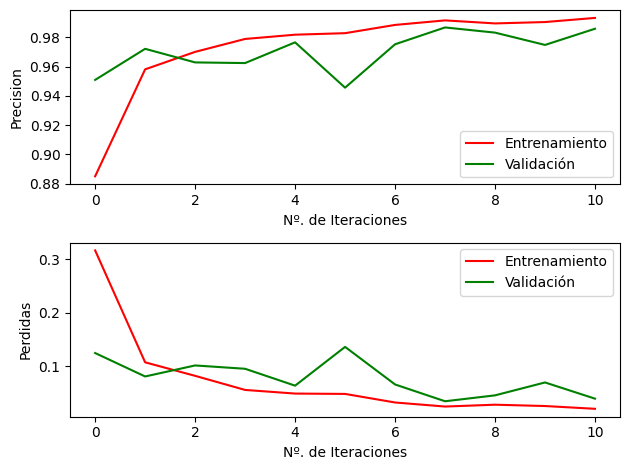

In [ ]:
accu = history_modded.history['categorical_accuracy']
val_acc = history_modded.history['val_categorical_accuracy']
loss = history_modded.history['loss']
val_loss = history_modded.history['val_loss']
epochs = range(len(accu))

# Representación de las perdidas
plt.subplot(211)
plt.plot(epochs,accu,'r',label='Entrenamiento')
plt.plot(epochs,val_acc,'g',label='Validación')
plt.xlabel('Nº. de Iteraciones')
plt.ylabel('Precision')
plt.legend()
# Representación de las perdidas
plt.subplot(212)
plt.plot(epochs,loss,'r',label='Entrenamiento')
plt.plot(epochs,val_loss,'g',label='Validación')
plt.xlabel('Nº. de Iteraciones')
plt.ylabel('Perdidas')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#print('model:')
#test_loss, test_acc = model.evaluate(test_data)
#print('Precisión del conjunto de prueba:', test_acc)
#print('Perdidas del conjunto de prueba:', test_loss)
print('mod_model:')
test_loss, test_acc = mod_model.evaluate(test_data)
print('Precisión del conjunto de prueba:', test_acc)
print('Perdidas del conjunto de prueba:', test_loss)

mod_model:
36/36 [==============================] - 8s 209ms/step - loss: 0.0326 - categorical_accuracy: 0.9883
Precisión del conjunto de prueba: 0.98828125
Perdidas del conjunto de prueba: 0.03261483460664749


In [ ]:
# Guardado del Modelo
save_path = "/content/drive/MyDrive/Repositorio_Modelos/Nuevos"
#model.save(save_path+'/MobileNetV2_Reentrenado_DataSet_224_Simple_V3.h5') # Modificar si no se deseea reescribir el modelo
mod_model.save(save_path+'/MobileNetV2_modificado_DataSet_224_Simple_V7.h5')

#Guardado unicamente de los pesos
#model.save_weights(save_path+'/MobileNetV2_Reentrenado_Pesos_DataSet_224_Simple_V3.h5')
mod_model.save_weights(save_path+'/MobileNetV2_modificado_Pesos_DataSet_224_Simple_V7.h5')

# Notas: Extraccón de pesos
#model.get_weights() 
#mod_model.get_weights() 

In [ ]:
# Cargado del modelo
save_path = "/content/drive/MyDrive/Repositorio_Modelos/Nuevos"
loaded_model = keras.models.load_model(save_path+'/MobileNetV2_modificado_DataSet_224_Simple_V7.h5')

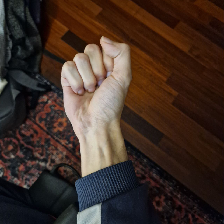

1/1 [==============================] - 0s 25ms/step
Mano_abierta 0.00025012094
Mano_cerrada 0.99974984
Salida: Mano_cerrada


In [ ]:
drive_path = "/content/drive/MyDrive/Trabajo_SCBIO"
img_path = drive_path+'/Fotos/photo_2023-05-18_22-35-37.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = loaded_model.predict(x)
for i in range(len(label_map)):
  print(label_map[i],preds[0][i]) 
print('Salida:', label_map[np.argmax(preds)]) 

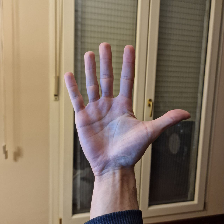

1/1 [==============================] - 0s 65ms/step
Mano_abierta 0.99999297
Mano_cerrada 7.0207834e-06
Salida: Mano_abierta


In [ ]:
drive_path = "/content/drive/MyDrive/Trabajo_SCBIO"
img_path = drive_path+'/Fotos/photo_2023-05-18_22-35-24.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = loaded_model.predict(x)
for i in range(len(label_map)):
  print(label_map[i],preds[0][i]) 
print('Salida:', label_map[np.argmax(preds)]) 

In [ ]:
# Notas: 
# DataSet renombrado a DataSet_224_Expandido_v2Gestos
# Modelo MobileNetV2_modificado_DataSet_224_Simple_V5.h5 renombrado a MobileNetV2_modificado_DataSet_224_Simple_v_1_Fin.h5 
# Modelo MobileNetV2_modificado_DataSet_224_Simple_V7.h5 renombrado a MobileNetV2_modificado_DataSet_224_Simple_v_2_Fin.h5